In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools
import numpy as np
import pandas as pd
import math
import random
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [335]:
def compute_synd_matrix(H, error):
    """
    Computes the syndrome matrix of the list of errors error
    x_z specifies if the error is an x-error or a z-error. True if x-error, False if z-error
        If error is an x-error we use the C1 x V2 checks
        If error is a z-error we use the V1 x C2 checks
    """
    n = H.shape[1]
    m = H.shape[0]

    bit_nbhd = []
    for bit in range(n):
        checks = np.where(H[:, bit])[0]
        bit_nbhd.append(checks)

    check_nbhd = []
    for check in range(m):
        bits = np.where(H[check])[0]
        check_nbhd.append(bits)

    vv_error, cc_error = error
    synd_matrix = [[False for c2 in range(m)] for v1 in range(n)]
    for v1, v2 in vv_error: # this is for V1 x C2 check nodes. Size of n x m
        for c2 in bit_nbhd[v2]:
            synd_matrix[v1][c2] = not synd_matrix[v1][c2]
    for c1, c2 in cc_error:
        for v1 in check_nbhd[c1]:
            synd_matrix[v1][c2] = not synd_matrix[v1][c2]

    return synd_matrix

In [336]:
def random_error(H, p):
    """
    Return a random iid error of proba 'p'
    """
    n = H.shape[1]
    m = H.shape[0]

    vv_xerror = [(v1,v2) for v1 in range(n) for v2 in range(n) if p > random.uniform(0,1)]
    cc_xerror = [(c1,c2) for c1 in range(m) for c2 in range(m) if p > random.uniform(0,1)]

    return (vv_xerror, cc_xerror)

In [337]:
# ccode = np.array(
#     [[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
#     [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
#     [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
#     [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
#     [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
#     [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
#     [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
#     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
#     [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
#     [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]]
# )

ccode = np.array(
[[0, 0, 1, 1, 1, 0],
 [1, 1, 0, 0, 1, 0],
 [1, 0, 0, 1, 0, 1]])
n = ccode.shape[1]
m = ccode.shape[0]

In [339]:
vv_errors, cc_errors = random_error(ccode, 0.05)
# vv_errors, cc_errors = ([(4, 0), (9, 5), (12, 13)], [(7, 2), (10, 4)])
vv_errors, cc_errors =([(0, 1)], [])
print(vv_errors, cc_errors)
synd = compute_synd_matrix(ccode, (vv_errors, cc_errors))
synd2 = compute_synd_matrix(ccode, (vv_errors, cc_errors))

[(0, 1)] []


In [340]:
print(np.array(synd))

[[False  True False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]]


In [341]:
# maskp = 0.00
# mask = [[False if maskp > np.random.uniform(0,1) else True for c2 in range(ccode.m)] for v1 in range(ccode.n)]
# print(np.array(mask))

In [342]:
synd_points = [(x,y) for x, y in zip(*np.where(synd))]

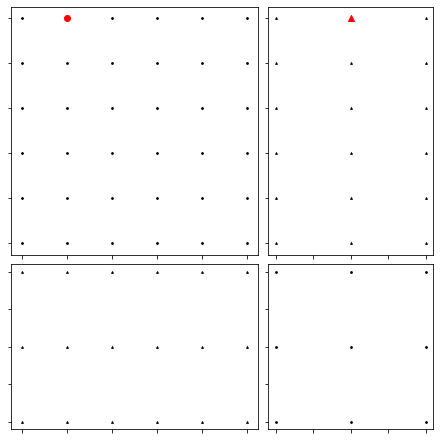

In [343]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        # ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True, figsize=(6,6))

gs = GridSpec(10, 10, figure=fig)
cut_off = 6
ax1 = fig.add_subplot(gs[:cut_off, :cut_off])
ax1.invert_yaxis()


# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[:cut_off, cut_off:])
ax2.invert_yaxis()

ax3 = fig.add_subplot(gs[cut_off:, :cut_off])
ax3.invert_yaxis()

ax4 = fig.add_subplot(gs[cut_off:, cut_off:])
ax4.invert_yaxis()
# ax5 = fig.add_subplot(gs[-1, -2])


format_axes(fig)
vv = itertools.product(np.arange(n), np.arange(n))
cc = itertools.product(np.arange(m), np.arange(m))

v1xc2 = itertools.product(np.arange(m), np.arange(n)) # checks of the z code
c1xv2 = itertools.product(np.arange(n), np.arange(m)) # checks of the x code

ax1.scatter(*zip(*vv), s=3, c='k') # vv qubits
ax1.scatter([vv[1] for vv in vv_errors], [vv[0] for vv in vv_errors], c='r')
# ax1.scatter([0], [5])

ax4.scatter(*zip(*cc), s=3, c='k') # cc qubits
ax4.scatter([cc[1] for cc in cc_errors], [cc[0] for cc in cc_errors], c='r')


ax3.scatter(*zip(*c1xv2), s=3, c='k', marker='^') # checks of the x code (z generators)
# ax3.scatter([e[1] for e in synd_points2], [e[0] for e in synd_points2], c='r', marker='^')
# ax3.scatter([5], [1], s=70, c='b')

ax2.scatter(*zip(*v1xc2), s=3, c='k', marker='^') # checks of the z code (x generators)
ax2.scatter([e[1] for e in synd_points], [e[0] for e in synd_points], c='r', marker='^')
# ax2.scatter([e[1] for e in synd_gen_ind], [e[0] for e in synd_gen_ind], alpha=0.5)
# ax2.scatter([e[1] for e in mask], [e[0] for e in mask], marker='x', s=100, c='k')


plt.show()

In [125]:
ver = ccode.check_nbhd[1] # list of qubits in c1
hor = ccode.bit_nbhd[5] # list of checks v2 is part of
synd_gen = [[synd[ver[i]][hor[j]]
    for j in range(len(hor))] for i in range(len(ver))] 
synd_gen

[[True, False], [False, True], [False, False], [False, True]]

In [131]:
synd_gen_temp = [[(ver[i], hor[j])
    for j in range(len(hor))] for i in range(len(ver))] 
synd_gen_ind = []
for i in range(len(ver)):
    for j in range(len(hor)):
        synd_gen_ind.append(synd_gen_temp[i][j])
synd_gen_ind

[(1, 1), (1, 2), (2, 1), (2, 2), (5, 1), (5, 2), (6, 1), (6, 2)]

Text(0.5, 1.0, 'Decoder failure rate vs p for a [[400, 16]] code')

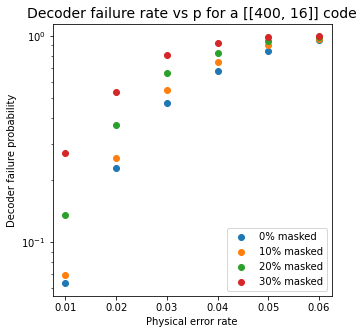

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ps = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
mask0 = [0.063, 0.228, 0.474, 0.678, 0.849, 0.955]
mask01 = [0.069, 0.255, 0.546, 0.746, 0.909, 0.962]
mask02 = [0.135, 0.371, 0.66, 0.824, 0.95, 0.988]
mask03 = [0.27, 0.535, 0.811, 0.922, 0.991, 0.996]

ax.scatter(ps, mask0, label='0% masked')
ax.scatter(ps, mask01, label='10% masked')
ax.scatter(ps, mask02, label='20% masked')
ax.scatter(ps, mask03, label='30% masked')

ax.set_xlabel('Physical error rate')
ax.set_ylabel('Decoder failure probability')
ax.set_yscale('log')
plt.legend(loc='lower right')
ax.set_title('Decoder failure rate vs p for a [[400, 16]] code', fontsize=14)


Text(0.5, 1.0, '[[2196, 36]]')

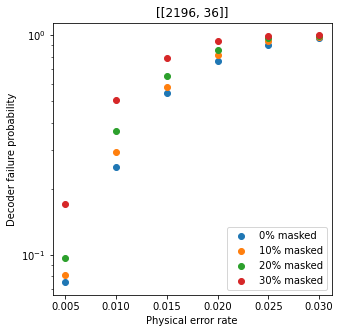

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ps = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
mask0 = [0.075, 0.251, 0.549, 0.764, 0.904, 0.972]
mask01 = [0.081, 0.295, 0.58, 0.812, 0.938, 0.986]
mask02 = [0.097, 0.368, 0.656, 0.862, 0.973, 0.996]
mask03 = [0.17, 0.51, 0.79, 0.946, 0.99, 1.0]

ax.scatter(ps, mask0, label='0% masked')
ax.scatter(ps, mask01, label='10% masked')
ax.scatter(ps, mask02, label='20% masked')
ax.scatter(ps, mask03, label='30% masked')

ax.set_xlabel('Physical error rate')
ax.set_ylabel('Decoder failure probability')
ax.set_yscale('log')
plt.legend(loc='lower right')
plt.title('[[2196, 36]]')

Text(0.5, 1.0, 'Decoder failure rate vs p for a [[6100, 100]] code')

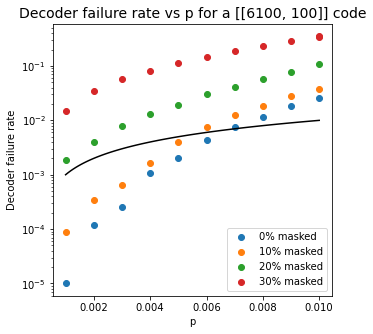

In [5]:
df = pd.read_csv('./prebuilt_code/ssf_masked/results/results.res')
df['p_error'] = 1 - df['p_log']

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(df[df['p_mask'] == 0.0]['p_phys'], df[df['p_mask'] == 0.0]['p_error'], label='0% masked')
ax.scatter(df[df['p_mask'] == 0.1]['p_phys'], df[df['p_mask'] == 0.1]['p_error'], label='10% masked')
ax.scatter(df[df['p_mask'] == 0.2]['p_phys'], df[df['p_mask'] == 0.2]['p_error'], label='20% masked')
ax.scatter(df[df['p_mask'] == 0.3]['p_phys'], df[df['p_mask'] == 0.3]['p_error'], label='30% masked')

ax.plot(np.linspace(1e-3,1e-2,100), np.linspace(1e-3, 1e-2, 100), c='k')
ax.set_yscale('log')
ax.legend(loc='lower right')
ax.set_ylabel('Decoder failure rate')
ax.set_xlabel('p')
ax.set_title('Decoder failure rate vs p for a [[6100, 100]] code', fontsize=14)
# ax.set_xscale('log')

Text(0.5, 1.0, '$p_{mask}$ = 0.0')

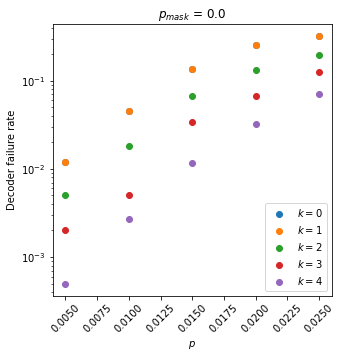

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)

df = pd.read_csv('./prebuilt_code/ssf_masked/results/res2.res')
df['p_error'] = 1 - df['p_log']
# cs = ['b','k','g','r']

ax.set_ylabel('Decoder failure rate')
for j in range(5):
    ax.scatter(df[(df['algo'] == j)]['p_phys'], df[(df['algo'] == j)]['p_error'], label=f'$k = {j}$')
ax.set_yscale('log')
# ax[i].set_xscale('log')
ax.legend(loc='lower right')
ax.set_xlabel('$p$')
plt.xticks(rotation = 45) 
ax.set_title('$p_{mask}$ = ' + f'{round(0*0.1,1)}')

Text(0.5, 0.98, 'Decoder failure rate vs p for a $[[400,16]]$ code')

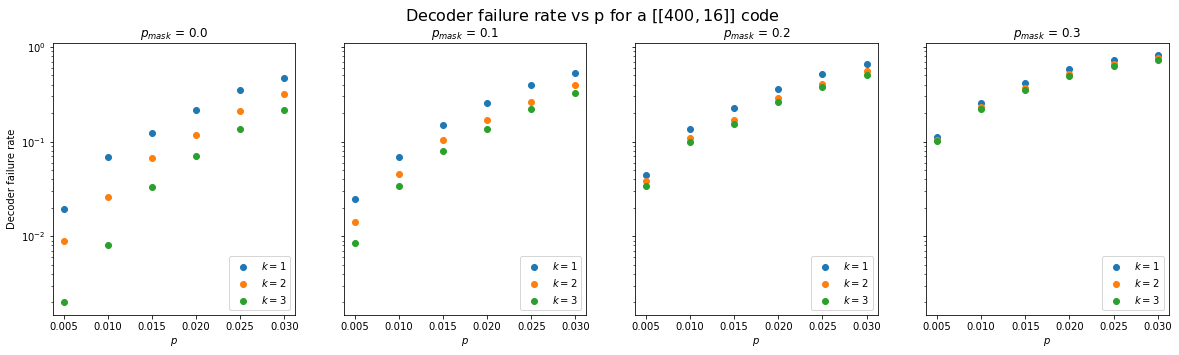

In [153]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True)

df = pd.read_csv('./prebuilt_code/ssf_masked/results/res_full.res')
df['p_error'] = 1 - df['p_log']
# cs = ['b','k','g','r']

for i in range(4):
    ax[0].set_ylabel('Decoder failure rate')
    for j in range(1,4):
        ax[i].scatter(df[(df['algo'] == j) & (df['p_mask'] == round(i*0.1,1))]['p_phys'], df[(df['algo'] == j) & (df['p_mask'] == round(i*0.1, 1))]['p_error'], label=f'$k = {j}$')
        ax[i].set_yscale('log')
        # ax[i].set_xscale('log')
        ax[i].legend(loc='lower right')
        ax[i].set_xlabel('$p$')
        ax[i].set_title('$p_{mask}$ = ' + f'{round(i*0.1,1)}')
fig.suptitle('Decoder failure rate vs p for a $[[400,16]]$ code', fontsize=16)

In [1]:
# fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True)

# df = pd.read_csv('./prebuilt_code/ssf_masked/results/res_full_list.res')
# df['p_error'] = 1 - df['p_log']
# cs = ['b','k','g','r']

# for i in range(4):
#     for j in range(1,4):
#         ax[i].scatter(df[(df['algo'] == j) & (df['p_mask'] == round(i*0.1,1))]['p_phys'], df[(df['algo'] == j) & (df['p_mask'] == round(i*0.1, 1))]['p_error'], label=f'$k = {j}$', c=cs[j], marker='o')
#         ax[i].scatter(df[(df['algo'] == -j) & (df['p_mask'] == round(i*0.1,1))]['p_phys'], df[(df['algo'] == -j) & (df['p_mask'] == round(i*0.1, 1))]['p_error'], label=f'$k = {j}$', c=cs[j], marker='x')

#         ax[i].set_yscale('log')
#         # ax[i].set_xscale('log')
#         ax[i].legend(loc='lower right')
#         ax[i].set_title('$p_{mask}$ = ' + f'{round(i*0.1,1)}')

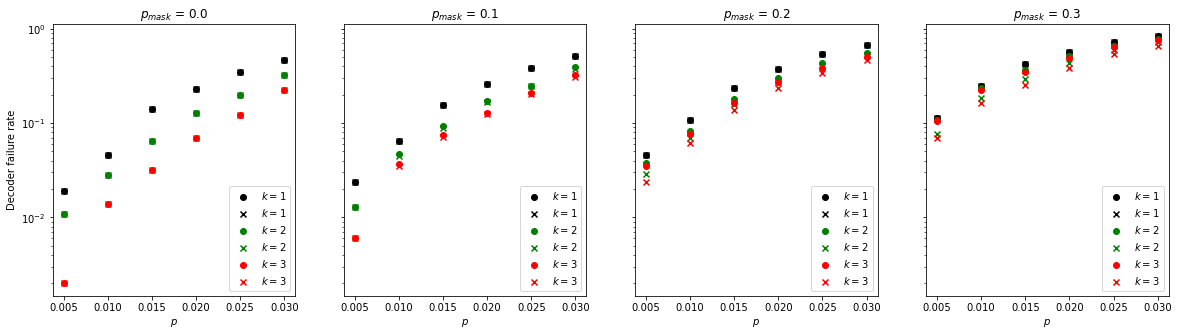

In [158]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True)

df = pd.read_csv('./prebuilt_code/ssf_masked/results/res_full_stab.res')
df['p_error'] = 1 - df['p_log']
cs = ['b','k','g','r']

for i in range(4):
    ax[0].set_ylabel('Decoder failure rate')
    for j in range(1,4):
        ax[i].scatter(df[(df['algo'] == j) & (df['p_mask'] == round(i*0.1,1))]['p_phys'], df[(df['algo'] == j) & (df['p_mask'] == round(i*0.1, 1))]['p_error'], label=f'$k = {j}$', c=cs[j], marker='o')
        ax[i].scatter(df[(df['algo'] == -j) & (df['p_mask'] == round(i*0.1,1))]['p_phys'], df[(df['algo'] == -j) & (df['p_mask'] == round(i*0.1, 1))]['p_error'], label=f'$k = {j}$', c=cs[j], marker='x')

        ax[i].set_yscale('log')
        # ax[i].set_xscale('log')
        ax[i].legend(loc='lower right')
        ax[i].set_xlabel('$p$')
        ax[i].set_title('$p_{mask}$ = ' + f'{round(i*0.1,1)}')

[0.18696143 1.00734197] [0.00110171 0.00822892] 0.9990944719635235
[0.38164836 0.99081408] [0.00419932 0.00944689] 0.9987193590293574
[0.60386994 0.99354962] [0.00733694 0.00841174] 0.9989134278607515
[0.84655417 0.99182298] [0.01091691 0.00804468] 0.9969257173648761
[0.96677316 1.01220756] [0.01262584 0.01431533] 0.9982926691200011


Text(0.5, 0, 'Effective $p$ ($t \\times p_0$)')

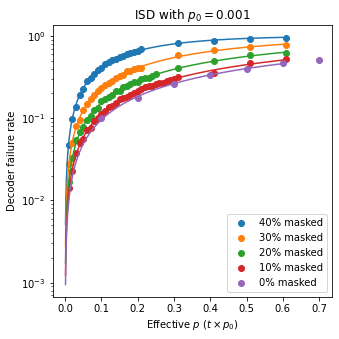

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)

df = pd.read_csv('./prebuilt_code/ssf_masked/results/naive_scheduling/24_20_5_6/iterative_masked_decoding.res')
df['p_error'] = 1 - df['p_log']
df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] / df['no_test'])
df['p_std_dev'].replace(to_replace=0, value=1, inplace=True)

def fun(x, a, b):
    return 1 - np.exp(-(x/a)**b)

# def fun(x, a):
    # return x / np.sqrt(x**2 + a)

# def fun(x, a):
#     return 1 - (a)**x

# def fun(x, a):
#     return (2/np.pi) * np.arctan(x/a)

for i in [0,1,2,3,4][::-1]:
    tmp_df = df[(df['p_mask'] == round(i*0.1,1)) & (df['algo']  % 10 ==  0)]
    ax.scatter(tmp_df['algo']/1000, tmp_df['p_error'], label=f'{i*10}% masked', marker='o')

    popt, pcov = curve_fit(fun, tmp_df['algo']/1000, tmp_df['p_error'], maxfev=1000,
        sigma=tmp_df['p_std_dev'], absolute_sigma=True,)
    print(popt, np.sqrt(np.diag(pcov)), r2_score(tmp_df['p_error'], fun(tmp_df['algo']/1000, *popt)))
    # print(popt[0])
    xx = np.linspace(0.001, 0.6, 1000)
    yy = fun(xx, *popt)
    ax.plot(xx, yy)


# ax.plot(np.linspace(0, 0.05, 100), np.linspace(1e-3, 50*1e-3, 100), c='k')
# ax[1].plot(np.linspace(1e-3,1e-2,100), np.linspace(1e-3, 1e-2, 100), c='k')

ax.set_title('ISD with $p_0 = 0.001$')
# ax[1].set_title('SSF with $k=1$')
ax.legend(loc='lower right')
ax.set_yscale('log')
ax.set_ylabel('Decoder failure rate')
ax.set_xlabel('Effective $p$ ($t \\times p_0$)')
# ax[1].set_xlabel('$p$')

[0.32107619 1.10285012] [0.00293031 0.01101092] 0.9975304765585822
[0.95941046 1.05088424] [0.00855289 0.00915257] 0.9978794027782585
[2.76838085 1.04542563] [0.05317646 0.009989  ] 0.998708111212299
[9.46297427 1.02567859] [0.37589335 0.01156195] 0.9925872293839544
[23.00506854  0.98742349] [1.33058136 0.01887844] 0.9878679400101061


Text(0.5, 0, 'Effective $p$ ($t \\times p_0$)')

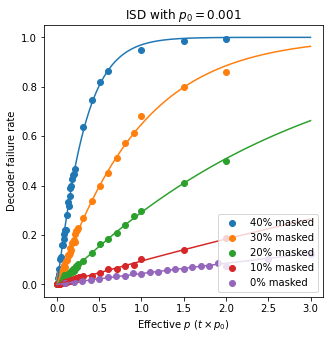

In [452]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)

df = pd.read_csv('./prebuilt_code/ssf_masked/results/naive_scheduling/36_30_5_6/iterative_masked_decoding.res')
df['p_error'] = 1 - df['p_log']
df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] / df['no_test'])
df['p_std_dev'].replace(to_replace=0, value=1, inplace=True)

# def fun(x, a, b):
#     return 1 - np.exp(-(x/a)**b)

for i in [0,1,2,3,4][::-1]:
    tmp_df = df[(df['p_mask'] == round(i*0.1,1)) & (df['algo']  % 10 ==  0)]
    ax.scatter(tmp_df['algo']/1000, tmp_df['p_error'], label=f'{i*10}% masked', marker='o')

    popt, pcov = curve_fit(fun, tmp_df['algo']/1000, tmp_df['p_error'], maxfev=1000,
        sigma=tmp_df['p_std_dev'], absolute_sigma=True,)
    print(popt, np.sqrt(np.diag(pcov)), r2_score(tmp_df['p_error'], fun(tmp_df['algo']/1000, *popt)))
    # print(popt[0])
    xx = np.linspace(0.001, 3, 1000)
    yy = fun(xx, *popt)
    ax.plot(xx, yy)


# ax.plot(np.linspace(0, 0.05, 100), np.linspace(1e-3, 50*1e-3, 100), c='k')
# ax[1].plot(np.linspace(1e-3,1e-2,100), np.linspace(1e-3, 1e-2, 100), c='k')

ax.set_title('ISD with $p_0 = 0.001$')
# ax[1].set_title('SSF with $k=1$')
ax.legend(loc='lower right')
# ax.set_yscale('log')
ax.set_ylabel('Decoder failure rate')
ax.set_xlabel('Effective $p$ ($t \\times p_0$)')
# ax[1].set_xlabel('$p$')

[0.34331064 1.10166955] [0.00302222 0.01592341]
[1.35503634 1.02764143] [0.01893193 0.01510973]
[6.05395639 1.02194756] [0.34643157 0.02785567]
[25.02460462  0.98230062] [11.57288397  0.11265848]


Text(0.5, 0, 'Effective $p$ ($t \\times p_0$)')

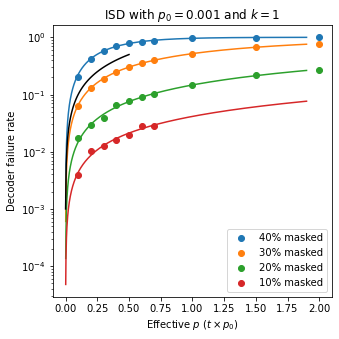

In [148]:
# https://stats.stackexchange.com/questions/430409/how-to-calculate-uncertainty-of-probability-derived-from-random-samples

fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)

df = pd.read_csv('./prebuilt_code/ssf_masked/results/naive_scheduling/42_35_5_6/iterative_masked_decoding.res')
df['p_error'] = 1 - df['p_log']
df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] / df['no_test'])
# df['p_std_dev'].replace(to_replace=0, value=1, inplace=True)

# def fun(x, a, b):
#     return 1 - np.exp(-(x/a)**b)

for i in [1,2,3,4][::-1]:
    tmp_df = df[df['p_mask'] == round(i*0.1,1)]
    ax.scatter(tmp_df['algo']/1000, tmp_df['p_error'], label=f'{i*10}% masked', marker='o')

    popt, pcov = curve_fit(fun, tmp_df['algo']/1000, tmp_df['p_error'],
      sigma=tmp_df['p_std_dev'], absolute_sigma=True,)
    print(popt, np.sqrt(np.diag(pcov)))
    # print(popt[0])
    xx = np.linspace(0.001, 1.9, 1000)
    yy = fun(xx, *popt)
    ax.plot(xx, yy)

ax.plot(np.linspace(0, 0.5, 100), np.linspace(1e-3, 500*0.001, 100), c='k')

ax.set_title('ISD with $p_0 = 0.001$ and $k=1$')
ax.legend(loc='lower right')
ax.set_yscale('log')
ax.set_ylabel('Decoder failure rate')
ax.set_xlabel('Effective $p$ ($t \\times p_0$)')

[0.33901634 1.19305792] [0.00192248 0.00973494]
[1.29560192 1.09546748] [0.03038331 0.02059   ]
[5.28897722 1.10924067] [0.43650241 0.03357027]
[31.55412168  0.98615904] [5.93999995 0.04213852]
[37.90120149  1.0326641 ] [5.35386484 0.04194741]


Text(0.5, 0, 'Effective $p$ ($t \\times p_0$)')

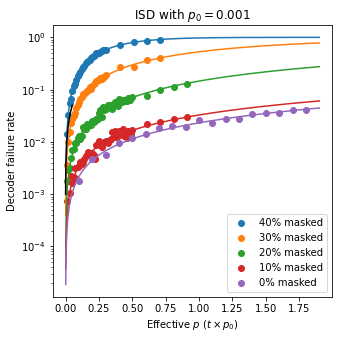

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)

df = pd.read_csv('./prebuilt_code/ssf_masked/results/naive_scheduling/48_40_5_6/iterative_masked_decoding.res')
df['p_error'] = 1 - df['p_log']
df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] * df['no_test'])
# df['p_std_dev'].replace(to_replace=0, value=1, inplace=True)

"""

DO MORE 0.2 RUNS

"""

def fun(x, a, b):
    return 1 - np.exp(-(x/a)**b)

for i in [0,1,2,3,4][::-1]:
    tmp_df = df[(df['p_mask'] == round(i*0.1,1)) & (df['algo']  % 10 ==  0)]
    ax.scatter(tmp_df['algo']/1000, tmp_df['p_error'], label=f'{i*10}% masked', marker='o')

    popt, pcov = curve_fit(fun, tmp_df['algo']/1000, tmp_df['p_error'], p0=(0.5,1),
        sigma=tmp_df['p_std_dev'])
    print(popt, np.sqrt(np.diag(pcov)))
    # print(popt[0])
    xx = np.linspace(0.001, 1.9, 1000)
    yy = fun(xx, *popt)
    ax.plot(xx, yy)


ax.plot(np.linspace(0, 0.05, 100), np.linspace(1e-3, 50*1e-3, 100), c='k')
# ax[1].plot(np.linspace(1e-3,1e-2,100), np.linspace(1e-3, 1e-2, 100), c='k')

ax.set_title('ISD with $p_0 = 0.001$')
# ax[1].set_title('SSF with $k=1$')
ax.legend(loc='lower right')
ax.set_yscale('log')
ax.set_ylabel('Decoder failure rate')
ax.set_xlabel('Effective $p$ ($t \\times p_0$)')
# ax[1].set_xlabel('$p$')

[7.43723736 1.10351005] [0.28453406 0.01368466]
[51.73445616  0.98533923] [6.37300651 0.02280755]


c:\Users\nfber\anaconda3\envs\qc\lib\site-packages\scipy\optimize\minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

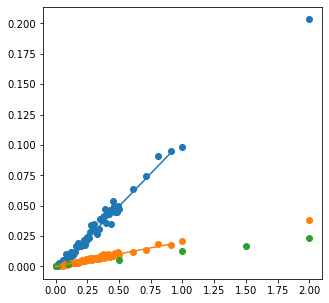

In [677]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)

df = pd.read_csv('./prebuilt_code/ssf_masked/results/naive_scheduling/60_50_5_6/iterative_masked_decoding.res')
df['p_error'] = 1 - df['p_log']
df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] / df['no_test'])
# df['p_std_dev'].replace(to_replace=0, value=1e-10, inplace=True)

def fun(x, a, b):
    return 1 - np.exp(-(x/a)**b)

for i in [0,1,2][::-1]:
    tmp_df = df[(df['p_mask'] == round(i*0.1,1)) & (df['algo']  % 10 ==  0)]
    ax.scatter(tmp_df['algo']/1000, tmp_df['p_error'], label=f'{i*10}% masked', marker='o')

    popt, pcov = curve_fit(fun, tmp_df['algo']/1000, tmp_df['p_error'], p0=(2,1),
        sigma=tmp_df['p_std_dev'], absolute_sigma=True)
    print(popt, np.sqrt(np.diag(pcov)))
    # print(popt[0])
    xx = np.linspace(0.001, 0.9, 1000)
    yy = fun(xx, *popt)
    ax.plot(xx, yy)
    # ax[0].plot(xx, yy1, 'b--')
    # ax[0].plot(xx, yy2, 'b--')
    # ax[0].fill_between(xx, yy1, yy2, facecolor="gray", alpha=0.15)


# ax.plot(np.linspace(0, 0.05, 100), np.linspace(1e-3, 50*1e-3, 100), c='k')
# ax[1].plot(np.linspace(1e-3,1e-2,100), np.linspace(1e-3, 1e-2, 100), c='k')

ax.set_title('ISD with $p_0 = 0.001$')
# ax[1].set_title('SSF with $k=1$')
ax.legend(loc='lower right')
ax.set_yscale('log')
ax.set_ylabel('Decoder failure rate')
ax.set_xlabel('Effective $p$ ($t \\times p_0$)')
# ax[1].set_xlabel('$p$')

In [159]:
# https://math.stackexchange.com/questions/1716156/sd-of-a-bernoulli-trial

codes = [
    "24_20_5_6",
    "30_25_5_6",
    "36_30_5_6",
    "42_35_5_6",
    "48_40_5_6",
    "60_50_5_6",
    "72_60_5_6",
    "84_70_5_6"
]

# sched = "progressive_scheduling"
sched = "naive_scheduling"

params = [[] for code in codes]
errors = [[] for code in codes]
code_sizes = np.array([int(code[0:2])**2 + int(code[3:5])**2 for code in codes])

for i, code in enumerate(codes):
    df = pd.read_csv(f'./prebuilt_code/ssf_masked/results/{sched}/{code}/iterative_masked_decoding.res')
    df['p_error'] = 1 - df['p_log']
    df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] / df['no_test'])

    def fun(x, a, b):
        return (1 - b*(1 - a)**x)

    p_masks = [0.0, 0.1, 0.2, 0.3, 0.4]
    for j, k in enumerate(p_masks):
        tmp_df = df[(df['p_mask'] == k) & (df['algo'] >= 100)]
        if (len(tmp_df)):
            popt, pcov = curve_fit(fun, tmp_df['algo']/1000, tmp_df['p_error'], p0=(0.0001,1), maxfev=1000,
                sigma=tmp_df['p_std_dev'])
            params[i].append(popt[0]/popt[1])
            errors[i].append(np.sqrt(np.diag(pcov))[0])
        else:
            params[i].append(0)
            errors[i].append(0)
params = np.array(params)
errors = np.array(errors)

0.0 [9.17830655 2.19220315] [2.79913364 0.14634284]
0.1 [6.09935709 1.87684311] [0.89981914 0.06373696]
0.2 [2.64160648 1.40652424] [0.22585981 0.02325448]
0.3 [1.41414822 1.13317378] [0.11065128 0.01390399]
0.4 [1.16966509 1.04001602] [0.01390962 0.00248002]


Text(0.5, 0, 'Distance')

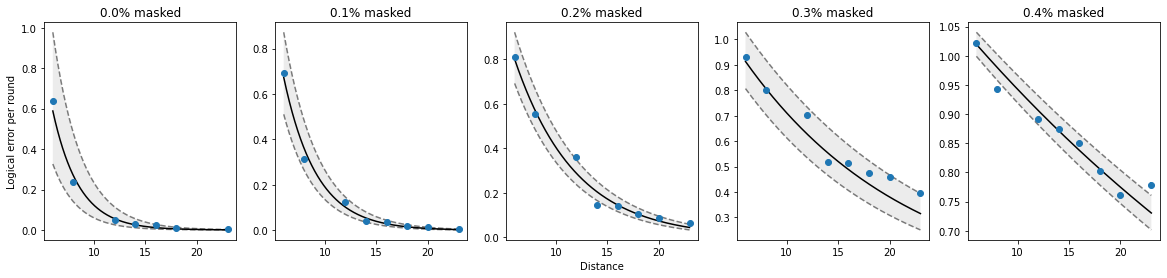

In [160]:
fig, ax = plt.subplots(1, len(p_masks), figsize=(4*len(p_masks),4))
distances = np.array([6, 8, 12, 14, 16, 18, 20, 23]) #  [6, 8, 12, 14, 16, 18, 20, 23]
lambdas = []

def fun(x, c, V):
    return c / (np.abs(V)**((x+1)/2))

for i, j in enumerate(p_masks):
    inds = np.where(params[:,i])
    ax[i].errorbar(distances[inds], params[:,i][inds], errors[:,i][inds], fmt="o" )
    # ax[i].scatter(distances, params[:,i][inds])
    popt, pcov = curve_fit(fun, distances[inds], params[:,i][inds], p0=(4, 2), maxfev=1000,
        sigma=errors[:,i][inds])
    print(j, popt, np.sqrt(np.diag(pcov)))
    std_dev = np.sqrt(np.diag(pcov))
    lambdas.append([popt[1], std_dev[1]])

    xx = np.linspace(distances[0], distances[-1], 1000)

    yy  = fun(xx, popt[0], popt[1])
    yy1 = fun(xx, popt[0] + std_dev[0], popt[1] - std_dev[1])
    yy2 = fun(xx, popt[0] - std_dev[0], popt[1] + std_dev[1])
    ax[i].plot(xx, yy, 'k')
    ax[i].plot(xx, yy1, 'k--', alpha=0.5)
    ax[i].plot(xx, yy2, 'k--', alpha=0.5)
    ax[i].fill_between(xx, yy1, yy2, facecolor="gray", alpha=0.15)

    ax[i].set_title(f"{j}% masked")
    # ax[i].set_yscale('log')
    # ax[i].set_xscale('log')

ax[0].set_ylabel('Logical error per round')
ax[2].set_xlabel('Distance')


Text(0.5, 0, 'Masking rate')

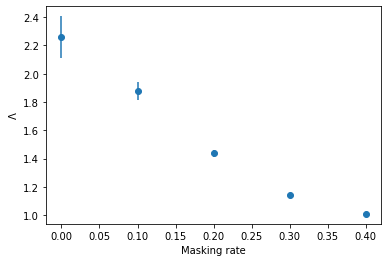

In [103]:
lambdas = np.array(lambdas)
plt.errorbar(p_masks, lambdas[:,0], lambdas[:,1], fmt='o')
plt.ylabel('$\Lambda$')
plt.xlabel('Masking rate')

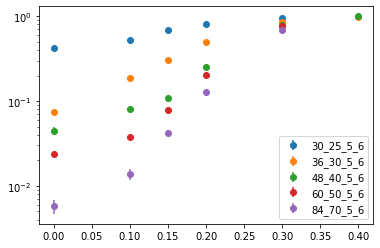

In [541]:
codes = [
    # "24_20_5_6",
    "30_25_5_6",
    "36_30_5_6",
    # "42_35_5_6",
    "48_40_5_6",
    "60_50_5_6",
    "84_70_5_6"
]

t = 2000
# sched = "progressive_scheduling"
sched = "naive_scheduling"

code_sizes = np.array([int(code[0:2])**2 + int(code[3:5])**2 for code in codes])

for i, code in enumerate(codes):
    df = pd.read_csv(f'./prebuilt_code/ssf_masked/results/{sched}/{code}/iterative_masked_decoding.res')
    df['p_error'] = 1 - df['p_log']
    df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] / df['no_test'])
    df = df[df['algo'] == t]

    plt.errorbar(df['p_mask'], df['p_error'], df['p_std_dev'], label=f"{codes[i]}", fmt='o')

plt.yscale('log')
plt.legend(loc='lower right')

In [540]:
codes = [
    "24_20_5_6",
    "30_25_5_6",
    "36_30_5_6",
    # "42_35_5_6",
    "48_40_5_6",
    "60_50_5_6",
    "84_70_5_6"
]

sched = "naive_scheduling"

code_sizes = np.array([int(code[0:2])**2 + int(code[3:5])**2 for code in codes])
full_df = pd.DataFrame()

for i, code in enumerate(codes):
    df = pd.read_csv(f'./prebuilt_code/ssf_masked/results/{sched}/{code}/iterative_masked_decoding.res')
    df['p_error'] = 1 - df['p_log']
    df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] / df['no_test'])
    full_df = pd.concat([full_df, df])

full_df.to_csv('full_iterative_masked_decoding.csv', index=False)

0.6379629144376435
0.23743282351826506
0.047112786978857284
0.029732460192116707
0.023689887863193385
0.011320651458304463
0.0032192480642595465


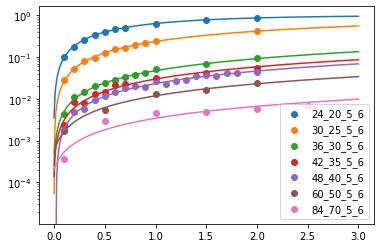

In [164]:
codes = [
    "24_20_5_6",
    "30_25_5_6",
    "36_30_5_6",
    "42_35_5_6",
    "48_40_5_6",
    "60_50_5_6",
    # "72_60_5_6",
    "84_70_5_6"
]

code_sizes = np.array([int(code[0:2])**2 + int(code[3:5])**2 for code in codes])
def fun(x, a, b):
    return (1 - b*(1 - a)**(x))
# def fun(x, a,):
#     return (1 - (1 - a)**(x))
params = []

for i, code in enumerate(codes):
    df = pd.read_csv(f'./prebuilt_code/ssf_masked/results/{sched}/{code}/iterative_masked_decoding.res')
    df['p_error'] = 1 - df['p_log']
    df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] / df['no_test'])

    p_masks = [0]
    for j, k in enumerate(p_masks):
        tmp_df = df[(df['p_mask'] == k) & (df['algo'] >= 100)]
        plt.scatter(tmp_df['algo']/1000, tmp_df['p_error'], label=f'{code}', marker='o')

        popt, pcov = curve_fit(fun, tmp_df['algo']/1000, tmp_df['p_error'], p0=(0.001, 1), maxfev=1000,
            sigma=tmp_df['p_std_dev'])
        params.append(popt[0])
        # print(code, popt, np.sqrt(np.diag(pcov)), r2_score(tmp_df['p_error'], fun(tmp_df['algo']/1000, *popt)))
        print(popt[0]/popt[1])
        xx = np.linspace(0.001, 3, 1000)
        yy = fun(xx, *popt)
        plt.plot(xx, yy)

plt.yscale('log')
plt.legend(loc='lower right')